In [1]:
import torch

c:\Miniconda\envs\yolov5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tensor = torch.rand(3,4)

In [4]:
tensor.to('cuda')

AssertionError: Torch not compiled with CUDA enabled

In [5]:
torch.cuda.is_available()

False

In [8]:
tensor.matmul(tensor.T)

tensor([[2.6936, 1.9774, 2.1987],
        [1.9774, 1.8984, 1.4137],
        [2.1987, 1.4137, 2.0091]])

In [14]:
tensor.add_(5)

tensor([[5.7105, 5.9005, 5.9659, 5.6670],
        [5.8073, 5.1809, 5.6936, 5.8560],
        [5.1718, 5.9249, 5.8947, 5.5690]])

In [11]:
torch.rand_like(tensor)

tensor([[0.8328, 0.0940, 0.0860, 0.7835],
        [0.0348, 0.4196, 0.5487, 0.8310],
        [0.6338, 0.9869, 0.2153, 0.6218]])

In [15]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 23838325.83it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 4918155.12it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 19653878.30it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5171802.87it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



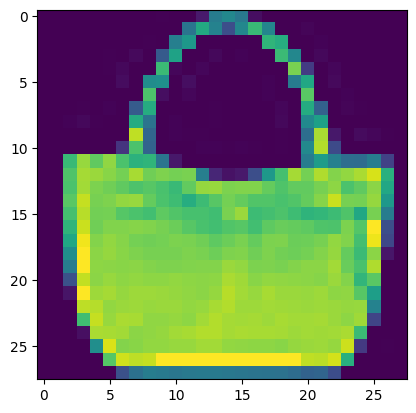

In [22]:
plt.imshow(training_data[100][0].squeeze())


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [57]:
next(iter(train_dataloader))[0].size()

torch.Size([64, 1, 28, 28])

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


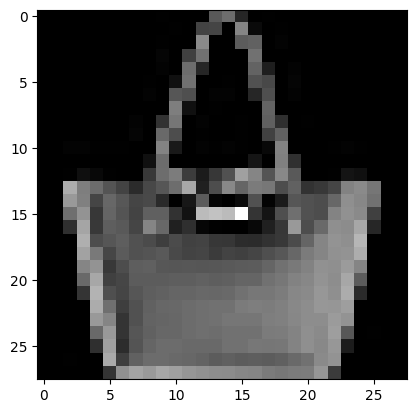

Label: 8


In [29]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [45]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)
ds

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Target transform: Lambda()

In [44]:
torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor([1,2,3]), value=1)

tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [47]:
ds.

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Target transform: Lambda()

In [48]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [50]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [58]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([5])


In [59]:
pred_probab

tensor([[0.1030, 0.1017, 0.0915, 0.0996, 0.1067, 0.1175, 0.1021, 0.0976, 0.0882,
         0.0922]], grad_fn=<SoftmaxBackward0>)

In [69]:
import torch

# with torch.no_grad():
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
# loss.backward()
b.grad

In [70]:
z.requires_grad

True

In [71]:
import holopy

In [81]:
from holopy import check_display
check_display()

pixels: x = 53, y = 57, z = 0, units: x = 5.3e+01, y = 5.7e+01, z = 0.0e+00,
pixels: x = 39, y = 41, z = 0, units: x = 3.9e+01, y = 4.1e+01, z = 0.0e+00,
pixels: x = 32, y = 60, z = 0, units: x = 3.2e+01, y = 6.0e+01, z = 0.0e+00,
pixels: x = 9, y = 50, z = 0, units: x = 9.3e+00, y = 5.0e+01, z = 0.0e+00,
pixels: x = 19, y = 40, z = 0, units: x = 1.9e+01, y = 4.0e+01, z = 0.0e+00,
pixels: x = 19, y = 40, z = 0, units: x = 1.9e+01, y = 4.0e+01, z = 0.0e+00,
pixels: x = 10, y = 42, z = 0, units: x = 1.0e+01, y = 4.2e+01, z = 0.0e+00,
pixels: x = 10, y = 42, z = 0, units: x = 1.0e+01, y = 4.2e+01, z = 0.0e+00,
pixels: x = 10, y = 42, z = 0, units: x = 1.0e+01, y = 4.2e+01, z = 0.0e+00,
pixels: x = 10, y = 42, z = 0, units: x = 1.0e+01, y = 4.2e+01, z = 0.0e+00,
pixels: x = 7, y = 10, z = 0, units: x = 7.5e+00, y = 1.0e+01, z = 0.0e+00,
pixels: x = 7, y = 9, z = 0, units: x = 7.5e+00, y = 9.0e+00, z = 0.0e+00,
pixels: x = 7, y = 8, z = 0, units: x = 7.5e+00, y = 8.2e+00, z = 0.0e+00,
pixel

In [76]:
%matplotlib tk

In [80]:

%matplotlib qt